# **Como construir um sistema de Backtest no Python usando Pandas**

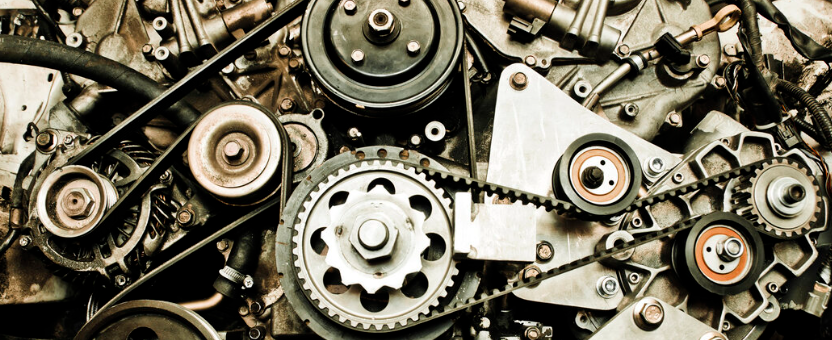

## ***1. Importar bibliotecas***

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

## ***2. Importar dados do ativo***

Iremos baixar os dados dos ultimos 20 anos da Amazon

In [4]:
amzn = yf.download('AMZN', '2000-01-01', '2020-01-01')

[*********************100%***********************]  1 of 1 completed


## ***3. Definir a estratégia de trading***

### *Criando a função*

Vamos usar a estratégia mais famosa: cruzamento de médias móveis.

Primeiramente, precisamos definir duas médias móveis simples:

In [5]:
def SMA(array, period):
    return array.rolling(period).mean()

A função tem três argumentos:

- dataset é o dataframe que contém os dados da ação que importamos previamente (AMZN),
- Array é a série que aplicaremos a função, neste caso o preço de fechamento (Close),
- períod é o comprimento da nossa média movel.

A função retorna uma "janela de preço deslizante" do comprimento desejado (period) de um valor(array) no qual é computada a média aritmética(.mean)


### *Definindo médias móveis*

Vamos definir duas médias móveis que usaremos. A primeira é a curta (14 dias), enquanto a segunda é a longa (200 dias):

In [6]:
sma14 = SMA(amzn['Close'], 14)
sma200 = SMA(amzn['Close'], 200)

Essas variáveis são Pandas Series

Agora, precisamos definir as regras de **entrada** e de **saída** da nossa estratégia.

Em outras palavras, temos:

- **Entrada(compra):** Quando a média rápida cruza pra cima da média longa. Chamamos de "crossover".
- **Saída(venda):** Quando a média rápida cruza pra baixo da média longa. Chamamos de "crossunder".


In [11]:
def crossover (array1, array2):
    return array1 > array2

def crossunder (array1, array2):
    return array1 < array2

Agora, atribuímos "crossover" para regra de entrada e "crossunder" para regra de saída:

In [13]:
enter_rules = crossover(sma14, sma200)
exit_rules = crossunder (sma14, sma200)

In [15]:
exit_rules

Date
2000-01-03    False
2000-01-04    False
2000-01-05    False
2000-01-06    False
2000-01-07    False
              ...  
2019-12-24     True
2019-12-26     True
2019-12-27     True
2019-12-30     True
2019-12-31     True
Name: Close, Length: 5031, dtype: bool

Basicamente, obtemos duas séries booleanas (True or False):

-**enter_rules** é True sempre que SMA14 > SMA200, enquanto

-**exit_rules** é True sempre que SMA14 < SMA200.

## ***4. Definir função de "Market Position"***

Aqui, vamos criar a função que define os trades em andamento: para alcançar isso,
criaremos um "interruptor" que:

-**Liga** se a enter_rules é True e exit_rules é False e
-**Desliga** se exit_rules é True

Vamos para a função:

In [17]:
def marketposition_generator(dataset, enter_rules, exit_rules):
    dataset['enter_rules'] = enter_rules
    dataset['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status ==0:
            if i==1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    dataset['mp'] = mp
    dataset['mp'] = dataset['mp'].shift(1)
    dataset.iloc[0,2] = 0
    
    return dataset['mp']
    

Vamos para a explicação:

-**dataset** é o DataFrame que contém os dados da ação (AMZN),

-**enter_rules** é o booleano que contem os sinais de entrada, e

-**exit_rules** é o booleano que contem os sinais de saída.

Nas duas primeiras linhas nós copiamos para nosso dataset as regras de entrada e saída.

**Status** é o interruptor e **mp** é uma lista vazia que será populada com os valores resultantes do **status**.

Agora criamos um loop com o zip, possibilitando fazer uma iteração paralela em enter_rules e exit_rules simultaneamente:

Isso retornará um único objeto iterador com todos os valores finalmente salvo na lista mp, que será:

- mp = 1(**on**): sempre que enter_values for True e exit_values for False, e
- mp = 0(**off**): sempre que exit_values for True.

**Nota:** No Python, True corresponde a 1 mas aqui, no "if j == -1" relacionado ao exit_rules, True é -1. Mais adiante ficará clara a razão disso.

Nas últimas 3 linhas, nós adicionamos mp no nosso dataset, shitmamos 1 a frente para o trade começar um dia após recebermos o sinal e na última linha nós substituimos
o valor nan, subsequente à operação shift, com zero. A função retorna a série mp.





## ***5. Definir função de "Backtest"***

Último passo, estamos perto do fim!

Primeiramente, precisamos definir alguns parâmetros, como:

-**Custos:** custos fixos por trade

-**Instrumento:** tipo de instrumento (1 para ação, 2 para futuros, etc.)

-**Capital Operacional:** Investimento inicial

-**Direção:** comprado ou vendido

-**Tipo de ordem:** A mercado, ordem limite, ordem stop, etc.

-**Nível de entrada:** Preço de entrada

In [19]:
costs = 0.50
instrument = 1
operation_money = 10000
direction = "long"
order_type = 'market'
enter_level = amzn['Open']

Estamos assumindo que:

-**Custos:** Cada operação custará 50 centavos, 25 para comprar e 25 para vender.

-**Instrumento:** o sistema testerá uma ação (amzn).
.
-**Capital Operacional:** 10 mil dólares.

-**Direção:** somente compra.

-**Tipo de ordem:** a estratégia processará ordens a mercado.

-**Nível de entrada:** O preço de entrada corresponde ao preço de abertura.


